# Project Overview

**HireScope** adalah sistem screening kandidat berbasis LLM yang memanfaatkan IBM Granite untuk mengklasifikasi dan menilai CV secara otomatis. Proses manual screening CV seringkali memakan waktu lama dan rentan terhadap bias, terutama saat harus menilai ratusan kandidat. HireScope hadir untuk membantu HRD dalam proses rekrutmen awal dengan memberikan insight objektif dan actionable dari ratusan CV dalam waktu singkat.

Model: **IBM Granite LLM**  
Dataset: Resume Dataset (Kaggle): https://www.kaggle.com/datasets/mdtalhask/ai-powered-resume-screening-dataset-2025  
Platform: Google Colab

## Environment Setup

Langkah pertama adalah mengintall depensi yang diperlukan untuk kalsifikasi ini, seperti:
- langchain_community, replicate untuk LLM inferensi
- kagglehub, pandas digunakan sebagai data handling
- matplotlib, seaborn sebagai visualisi data
- python-dotenv untuk memuat api key
- StringIO agar dapat membuat file like object untuk operasi text
- Sklearn digunakan sebagai mengevaluasi score model

In [164]:
#Uncomment ini jika inggin menginstall
#!pip install langchain_community replicate kagglehub[pandas-datasets] pandas matplotlib seaborn python-dotenv

In [165]:
import os
from langchain_community.llms import Replicate
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from io import StringIO as strIO
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#Memuat API key dari eviroment file
load_dotenv()
REPLICATE_API_TOKEN = os.environ["REPLICATE_API_TOKEN"]

#Uncomment ini jika menggunakan lingkungan colab, sesuaikan scret di colab sama seperti milik anda
#from google.colab import userdata
#REPLICATE_API_TOKEN = userdata.get('replicate_token')


# Example inference function for IBM Granite model
llm = Replicate(
    model= "ibm-granite/granite-3.3-8b-instruct",
    replicate_api_token=REPLICATE_API_TOKEN
)

## Dataset Preparation

Memuat dataset dan menampilkan

In [166]:
#Uncomment ini jika anda menggunakan kagglehub
#resume_df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, "mdtalhask/ai-powered-resume-screening-dataset-2025", path="AI_Resume_Screening.csv")

#Memuat dataset jika anda mendownloadnya, letakan satu folder sama notebook ini
resume_df = pd.read_csv("AI_Resume_Screening.csv")

#Menampilkan ringkasan dataset dari jumlah hingga barisnya
print(f"Loaded dataset with {len(resume_df)} rows")
resume_df.head(5)

Loaded dataset with 1000 rows


,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100


## Data Visualization

Memvisualisasi data agar lebih paham

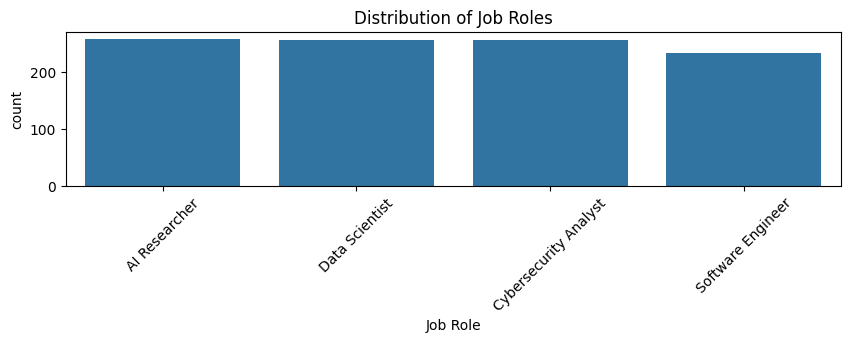

C:\Users\UseR\AppData\Local\Temp\ipykernel_14940\2860476490.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\UseR\AppData\Local\Temp\ipykernel_14940\2860476490.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\UseR\AppData\Local\Temp\ipykernel_14940\2860476490.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\UseR\AppData\Local\Temp\ipykernel_14940\2860476490.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `

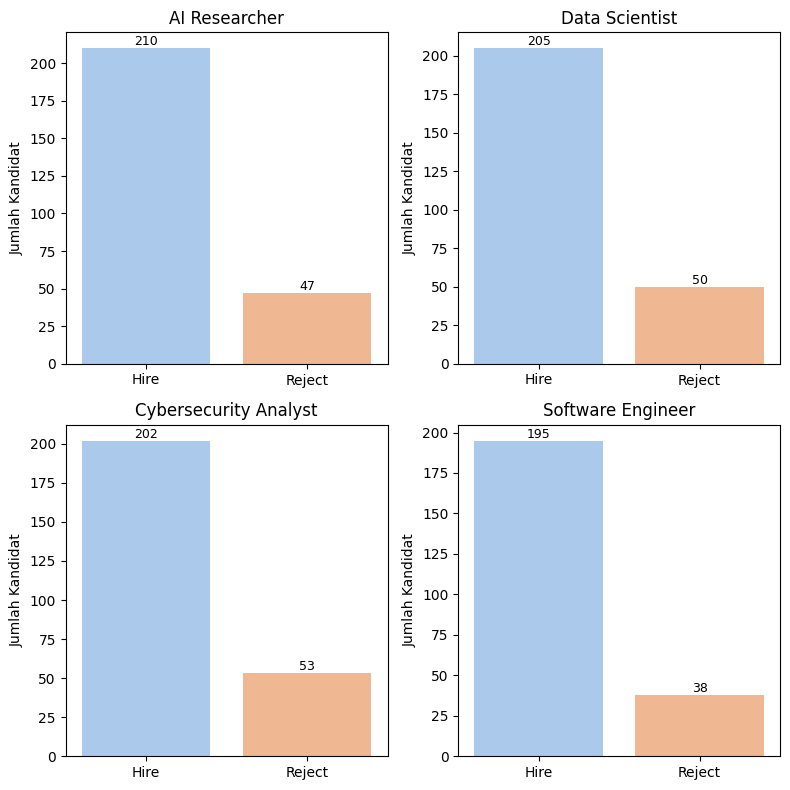

In [167]:
#memvisualisasi data berdasarkan distribusi Job role
plt.figure(figsize=(10, 2))
sns.countplot(data=resume_df, x='Job Role', order=resume_df['Job Role'].value_counts().index)
plt.title('Distribution of Job Roles')
plt.xticks(rotation=45)
plt.show()

#Visualisasi setiap Job `hire` dan `reject`
job_roles = resume_df['Job Role'].unique()

plt.figure(figsize=(8, 8))

for index, role in enumerate(job_roles):
    plt.subplot(2, 2, index + 1)
    
    subset = resume_df[resume_df['Job Role'] == role]
    
    ax = sns.countplot(
        x='Recruiter Decision',
        data=subset,
        order=subset['Recruiter Decision'].value_counts().index,
        palette='pastel'
    )
    
    plt.title(f"{role}")
    plt.xlabel('')
    plt.ylabel('Jumlah Kandidat')
    
    # menambahkan angka pada bar chart
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )

plt.tight_layout()
plt.show()


## Preprocessing

Membersihkan data kolom yang tidak kepakai('Resume_ID', 'Salary Expectation ($)')

In [ ]:
# meng eliminasi kolom yang tidak digunakan
cleaned_df = resume_df.drop(['Resume_ID', 'Salary Expectation ($)'], axis=1)


# Mengambil sample acak sebanyak 18
sample_df = cleaned_df.sample(18)

#Medefiniskan format profile 
def format_profile(row):
    return f"""
Entry: {row.name}
Name: {row['Name']}
Job Role: {row['Job Role']}
Skills: {row['Skills']}
Experience: {row['Experience (Years)']} years
Certifications: {row['Certifications']}
Education: {row['Education']}
Projects: {row['Projects Count']}
    """

# Melakukann format profile sesuai yg ditentukan
candidate_profiles = "".join(sample_df.apply(format_profile, axis=1))

# Melihat data yang sudah diacak
sample_df.head()

,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Projects Count,AI Score (0-100)
466,Monica Armstrong,"Pytorch, Python, TensorFlow, NLP",5,B.Sc,Google ML,AI Researcher,Hire,10,100
355,Vincent Daniel,"Python, Pytorch, TensorFlow, NLP",7,B.Sc,Google ML,AI Researcher,Hire,7,100
458,Scott Fisher,"Java, C++",4,B.Tech,Deep Learning Specialization,Software Engineer,Hire,8,100
493,Paula Fletcher,"Machine Learning, Python, SQL",6,B.Tech,Deep Learning Specialization,Data Scientist,Hire,8,100
441,Benjamin Ward,"Networking, Cybersecurity",5,MBA,NaN,Cybersecurity Analyst,Hire,6,90


## Prompt Engineering & finetuning parameter
Melakukan prompting dan tuning parameter agar mendapatkan. Hasil yang di ingingkan

**Penulisan prompting**
Penggunaan prompt dengan metode clarity(kejelasan), context(konteks), example(contoh) hal ini sangatlah membantu LLM untuk memahami apa yang dinginkan. Sebagai contoh kita ingin mengklasifikasikan kandidat berdasarkan catatan resume. Saya memberikan aturan agar LLM dapat mendapatkan konteks apa yang saya kehendaki seperti dibawah ini

**Finetuning parameter**
Meskipun telah menyusun prompt yang bagus, namun ada akalnya juga model luput atau bahkan halusinasi. Disinilah finetune parameters berperan dengan mengubah top_k=0 kita bisa membuat model untuk lebih fokus pada konteks prompting

In [212]:
#Prompting and finetuning with parameter

template = """
You are an AI assistant that evaluates resumes. Perform SYSTEMATIC analysis:

STEP 1: Extract key information from each candidate
STEP 2: Score each category using these rules:
  - Skills: >3 skills=4, 2-3=2, ≤1=0
  - Experience: >5y=3, 1-5y=2, <1y=0
  - Certifications: ≥1 cert=2, none=0  
  - Education: PhD=2, Master's=1, Bachelor's=0
  - Projects: >3=2, 1-3=1, none=0

STEP 3: Apply decision rule: 
  Hire if Skills≥3 AND Experience≥2 AND (Cert≥1 OR Edu≥1 OR Proj≥1)

STEP 4: Output results in CSV format

Reason: This structured approach ensures fair and consistent evaluation.

Candidate data:
{candidate_profiles}

Following this output CSV ONLY, no text outside of template, dont give your brief. Desire template (entry,name,decision,skill_score,experience_score,certification_score,education_score,project_score,total_score):
121,Bob,Hire,4,2,2,0,2
245,Alice,Reject,3,2,2,1,0
"""

# Mengaplikasikan candidate_profil dengan prompt 
prompt3 = template.replace("{candidate_profiles}", candidate_profiles)

# Melakukan adjustment parameters
parameters = {
    "top_k": 0,
    "top_p": 1.1,
    "max_tokens": 512,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.3,
    "stopping_sequence": None,
    "stopping_criteria": ["Note", "Explanation", "Summary"]
}

# Melakukan inferensi dengan LLM Replcate 
response = llm.invoke(
    prompt3,
    parameters=parameters
)

# Melihat response
print(response)

466,Monica Armstrong,Hire,4,3,2,0,2,11
355,Vincent Daniel,Hire,4,3,2,0,2,11
458,Scott Fisher,Reject,2,1,2,1,7,13
493,Paula Fletcher,Hire,4,3,2,0,2,11
441,Benjamin Ward,Reject,2,3,0,1,6,12
333,William Walker,Hire,3,2,2,1,1,10
774,Amy White,Hire,4,2,0,1,8,15
778,Matthew Smith,Hire,4,3,0,1,4,12
726,Ryan Mason,Hire,4,3,0,1,5,13
169,Ruth Prince,Reject,4,3,0,2,0,9
208,Derrick Mendoza,Hire,4,2,2,1,6,15
223,Jon Poole,Hire,3,3,2,1,4,15
138,Tyler Henderson,Hire,4,2,0,1,7,14
277,Dwayne Taylor,Hire,4,3,2,1,7,17
121,Robert Carey,Reject,4,2,2,0,2,10
859,Terry Simpson,Hire,4,3,2,1,9,19
457,Keith Hayes,Hire,4,3,0,2,9,18
302,Amber Dalton,Hire,4,2,2,1,10,19


In [214]:
# Melakukan ekstrasi dari response LLM ke csv
granite_decision = pd.read_csv(
    strIO(response), names=[
                    "entry", 
                    "name", 
                    "decision", 
                    "skill_score", 
                    "experience_score", 
                    "certification_score", 
                    "education_score", 
                    "project_score", 
                    "total_score"
                        ]
)

# Mencetak hasil ekstraksi
#granite_decision = granite_decision.dropna()
granite_decision

,entry,name,decision,skill_score,experience_score,certification_score,education_score,project_score,total_score
0,466,Monica Armstrong,Hire,4,3,2,0,2,11
1,355,Vincent Daniel,Hire,4,3,2,0,2,11
2,458,Scott Fisher,Reject,2,1,2,1,7,13
3,493,Paula Fletcher,Hire,4,3,2,0,2,11
4,441,Benjamin Ward,Reject,2,3,0,1,6,12
5,333,William Walker,Hire,3,2,2,1,1,10
6,774,Amy White,Hire,4,2,0,1,8,15
7,778,Matthew Smith,Hire,4,3,0,1,4,12
8,726,Ryan Mason,Hire,4,3,0,1,5,13
9,169,Ruth Prince,Reject,4,3,0,2,0,9


## Evaluation and Conclusion

Summarize results and discuss implications for HR screening.

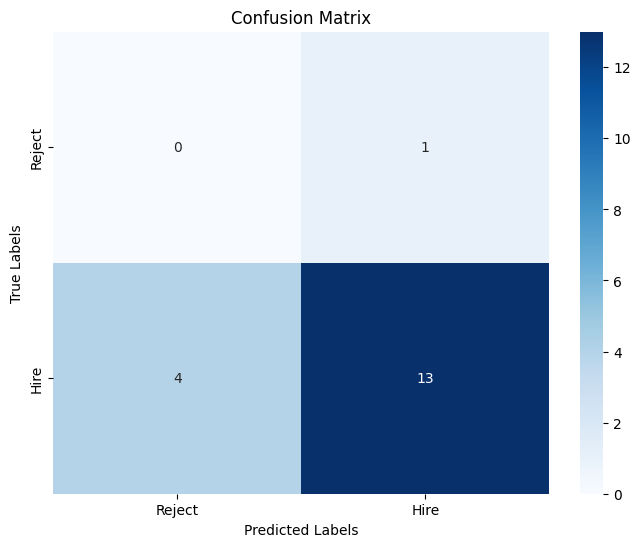

,Evaluation,Score
0,Accuracy,0.72
1,Precision,0.93
2,Recall,0.76
3,F1-Score,0.84


In [215]:
# Melakukan binary labeling
y_true = sample_df["Recruiter Decision"].map({'Hire': 1, 'Reject': 0})
y_pred = granite_decision["decision"].map({'Hire': 1, 'Reject': 0})

# Menghitung model score
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

label = ["Reject", "Hire"]
labeled_cm = pd.DataFrame(cm, index=label, columns=label)

model_score = {
    "Evaluation": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Score": [f"{acc:.2f}", f"{prec:.2f}", f"{rec:.2f}", f"{f1:.2f}"]
}


#Display confusion_matrix score
plt.figure(figsize=(8, 6))
sns.heatmap(labeled_cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Model Accuracy, Precision, Recall, F1 score
df_score = pd.DataFrame(data=model_score)
df_score